# Introduction to LangGraph

In this tutorial, we'll build a customer support chatbot. We'll start with a simple model and gradually add more functionality, introducing key LangGraph concepts along the way. By the end, you will have built a chat bot that can:

- Answer common questions by searching a knowledge base
- Route complex queries to a human agent for review
- Maintain conversation state across sessions

Through the process, we will learn key LangGraph concepts like graph construction, edges, human-in-the-loop workflow, and persistence.

## Setup

First, install the required packages:

In [2]:
%%capture --no-stderr
%pip install -U langgraph langsmith

# Used for this tutorial; not a requirement for LangGraph
%pip install -U langchain langchain_anthropic

Next, set your API keys:

In [4]:
import getpass
import os


def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")


_set_env("ANTHROPIC_API_KEY")

(Encouraged) [LangSmith](https://smith.langchain.com/) makes it a lot easier to see what's going on "under the hood."

In [140]:
_set_env("LANGSMITH_API_KEY")
os.environ["LANGCHAIN_TRACING_V2"] = "true"

## Part 1: Build a Chat Bot

Let's first create a basic chat bot in LangGraph. The chat bot can respond to user messages and maintain a basic chat history.

First, create a `MessageGraph`. We will later add `nodes` and `edges` to this object to define how we want to chat bot to behave. 

In [26]:
from langgraph.graph import MessageGraph

graph_builder = MessageGraph()

Next, add a "`chatbot`" node.

In [27]:
from langchain_anthropic import ChatAnthropic

chatbot = ChatAnthropic(model="claude-3-haiku-20240307")
# The first argument is the unique node name
# The second argument is the function or object that will be called whenever
# the node is used.
graph_builder.add_node("chatbot", chatbot)

Next, add a `entry` point. This tells our graph where to start its work any time we run it.

In [28]:
graph_builder.set_entry_point("chatbot")

Similarly, set a `finish` point. This tells the graph "any time this node is run, you can exit."

In [31]:
graph_builder.set_finish_point("chatbot")

Finally, let's "compile" the graph. This creates a "CompiledGraph" we then run.

In [32]:
graph = graph_builder.compile()

Now let's run the chatbot!

In [35]:
while True:
    user_input = input("User: ")
    if user_input.lower() in ["quit", "exit", "q"]:
        print("Goodbye!")
        break
    for event in graph.stream(("user", user_input)):
        for value in event.values():
            print("Assistant:", value.content)

User:  Hi


Assistant: Hello! How can I assist you today?


User:  I'm learning about langgraph. What are you up to?


Assistant: I don't have any specific plans or activities. As an AI assistant, I'm here to have conversations and provide helpful information to you to the best of my abilities. What would you like to discuss regarding langgraph or anything else? I'm happy to chat and share what I know.


User:  q


Goodbye!


Congrats! You've built a simple chatbot using LangGraph. You can visualize the graph using the `get_graph` and one of the `draw_ascii` or `draw_png` methods (though `draw_png` comes with some other dependencies).

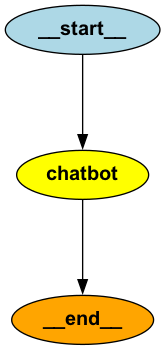

In [37]:
try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except:
    # This requires some extra dependencies and is optional
    pass

Below is the full code for this section for reference:

```python
from langgraph.graph import MessageGraph
from langchain_anthropic import ChatAnthropic

graph_builder = MessageGraph()

chatbot = ChatAnthropic(model="claude-3-haiku-20240307")
# The first argument is the unique node name
# The second argument is the function or object that will be called whenever
# the node is used.
graph_builder.add_node("chatbot", chatbot)
graph_builder.set_entry_point("chatbot")
graph_builder.set_finish_point("chatbot")
graph = graph_builder.compile()
```

## Part 2: Add Tools

Our chat bot needs relevant, up-to-date information to helpfully assist our users. This means it needs to access a search engine, database, or other type of retriever.

For our tutorial, we will give our chat bot the option to query a general web search engine to answer questions.

#### Requirements

First, install the requirements to use the [Tavily Search Engine](https://python.langchain.com/docs/integrations/tools/tavily_search/), and set your [TAVILY_API_KEY](https://tavily.com/).

In [ ]:
%%capture --no-stderr
%pip install -U tavily-python

In [ ]:
_set_env("TAVILY_API_KEY")

Next, define the tool:

In [78]:
from langchain_community.tools.tavily_search import TavilySearchResults

tool = TavilySearchResults(max_results=2)
tools = [tool]
tool.invoke("What's a 'node' in LangGraph?")

[{'url': 'https://medium.com/@cplog/introduction-to-langgraph-a-beginners-guide-14f9be027141',
  'content': 'Nodes: Nodes are the building blocks of your LangGraph. Each node represents a function or a computation step. You define nodes to perform specific tasks, such as processing input, making ...'},
 {'url': 'https://langchain-ai.github.io/langgraph/tutorials/chat_agent_executor_with_function_calling/prebuilt-tool-node/',
  'content': 'Define the nodes. We now need to define a few different nodes in our graph. In langgraph, a node can be either a function or a runnable . There are two main nodes we need for this: The agent: responsible for deciding what (if any) actions to take. MODIFICATION The prebuilt ToolNode, given the list of tools.'}]

Next, we'll start defining our graph. The following is all the same as in Part 1, except we have called `bind_tools` on our LLM. This lets it know the correct schema to return if it wants to use our search engine.

In [82]:
from langchain_anthropic import ChatAnthropic

from langgraph.graph import MessageGraph

graph_builder = MessageGraph()

chatbot = ChatAnthropic(model="claude-3-haiku-20240307")
graph_builder.add_node("chatbot", chatbot.bind_tools(tools))

Now we'll add the tools to a new node. The `ToolNode` is a helper class in LangGraph that `invoke`'s the selected tools whenever the LLM responds with 1 or more tool calls. It relies on `tool_calling` support, which is available in Anthropic, OpenAI, Google Gemini, and a number of other LLM providers.

In [83]:
from langgraph.prebuilt import ToolNode

tool_node = ToolNode(tools=[tool])
graph_builder.add_node("action", tool_node)

With the tool node added, we can define the conditional graph logic. If the LLM decides to call a tool, we will route to the "action" node. Otherwise, we will route to the "`__end__`" of the graph (equivalent to the finish point above) to respond to the user.

In [84]:
def tools_called(state: list):
    # In MessageGraph, the 'state' is a list of chat messages
    ai_message = state[-1]
    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
        return "action"
    return "__end__"


# Any time the chatbot responds, we will have to decide whether to
# act (call the search engine) or end
graph_builder.add_conditional_edges("chatbot", tools_called)
# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("action", "chatbot")
graph_builder.set_entry_point("chatbot")
graph = graph_builder.compile()

Notice that the function we provide the `conditional_edge` accepts the graph's `state` (in our case, a list of messages) and returns with logic that determines the next node to call.

We also have to add a simple directed edge back from `action` to `chatbot` so that the LLM can decide what to do next.

Since we return "__end__" in the conditional edge, we don't have to explicitly set the `finish_point` this time (our graph already has a way to finish).

Let's visualize the graph we've built. The following function

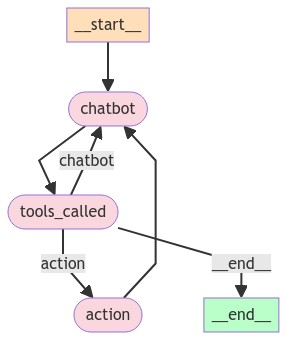

In [85]:
try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except:
    # This requires some extra dependencies and is optional
    pass

Now we can ask the bot questions about current information.

In [87]:
from langchain_core.messages import BaseMessage

while True:
    user_input = input("User: ")
    if user_input.lower() in ["quit", "exit", "q"]:
        print("Goodbye!")
        break
    for event in graph.stream(("user", user_input)):
        for value in event.values():
            if isinstance(value, BaseMessage):
                print("Assistant:", value.content)

User:  Hi there


Assistant: Hello! How can I assist you today?


User:  Trying to learn langgraph. Know anything on the subject?


Assistant: [{'id': 'toolu_01D3uPT35HLYwWZoekhn3Kzx', 'input': {'query': 'langgraph'}, 'name': 'tavily_search_results_json', 'type': 'tool_use'}]
Assistant: Based on the search results, here's what I've learned about langgraph:

Langgraph is a library that extends the LangChain framework to enable the creation of multi-agent workflows and stateful applications using large language models (LLMs). Some key things about langgraph:

- It allows for the coordination of multiple LLM-powered "agents" or chains across multiple steps of computation, including cycles and feedback loops. This is in contrast to the more linear workflows of the basic LangChain AgentExecutor.

- It is integrated with the broader LangChain ecosystem, allowing you to leverage LangChain's various integrations and observability features.

- It provides runtimes and examples that demonstrate how to set up these multi-agent workflows, including examples of message passing between agents.

- Langgraph is available in both P

User:  q


Goodbye!


**Congrats!** You've created a conversational agent in langgraph by adding tools to your bot. The full code for the graph we've created in this section is reproduced below:

```python
from langchain_anthropic import ChatAnthropic
from langchain_community.tools.tavily_search import TavilySearchResults

from langgraph.graph import MessageGraph
from langgraph.prebuilt import ToolNode

tool = TavilySearchResults(max_results=2)
tools = [tool]


graph_builder = MessageGraph()

chatbot = ChatAnthropic(model="claude-3-haiku-20240307")
graph_builder.add_node("chatbot", chatbot.bind_tools(tools))

tool_node = ToolNode(tools=[tool])
graph_builder.add_node("action", tool_node)


def tools_called(state: list):
    ai_message = state[-1]
    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
        return "action"
    return "__end__"


graph_builder.add_conditional_edges("chatbot", tools_called)
graph_builder.add_edge("action", "chatbot")
graph_builder.set_entry_point("chatbot")
graph = graph_builder.compile()
```

## Part 3: Checkpointing

Our chat bot can now handle chit chat and use tools to respond to questions, but what happens if an error happens midway? Or what if a user wants to pick up mid-conversation, ignoring some of the later steps?

LangGraph handles this by letting you `persist` state on each graph transition through a configurable checkpointer.

Any time you provide a checkpointer, you can call your graph along with a `thread_id`. Checkpoints are automatically loaded for each subsequent interaction with the graph within that `thread`.

First, create a checkpointer.

In [150]:
from langgraph.checkpoint.sqlite import SqliteSaver

memory = SqliteSaver.from_conn_string(":memory:")

Notice that we've specified `:memory` as the Sqlite DB path. This is convenient for our tutorial, but in a real application, you would change this to an existing DB and/or use one of the other checkpointer classes.

Next define the graph. This is all copied from Part 2.

In [151]:
from langchain_anthropic import ChatAnthropic
from langchain_community.tools.tavily_search import TavilySearchResults

from langgraph.graph import MessageGraph
from langgraph.prebuilt import ToolNode

tool = TavilySearchResults(max_results=2)
tools = [tool]


graph_builder = MessageGraph()

chatbot = ChatAnthropic(model="claude-3-haiku-20240307")
graph_builder.add_node("chatbot", chatbot.bind_tools(tools))

tool_node = ToolNode(tools=[tool])
graph_builder.add_node("action", tool_node)


def tools_called(state: list):
    ai_message = state[-1]
    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
        return "action"
    return "__end__"


graph_builder.add_conditional_edges("chatbot", tools_called)
graph_builder.add_edge("action", "chatbot")
graph_builder.set_entry_point("chatbot")

Finally, compile the graph with the provided checkpointer.

In [152]:
graph = graph_builder.compile(checkpointer=memory)

Now you can interact with your bot. First, pick a thread to use as the key for this conversation.

In [153]:
import uuid

thread_id = uuid.uuid4()

config = {"configurable": {"thread_id": "1"}}

Next, call your chat bot.

In [154]:
user_input = "Hi there! My name is Will."

# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(("user", user_input), config)
for event in events:
    for value in event.values():
        if isinstance(value, BaseMessage):
            print("Assistant:", value.content)

Assistant: It's nice to meet you, Will! I'm an AI assistant here to help out however I can. Please let me know if you have any questions or if there's anything I can assist you with.


**Note:** The config was provided as the second positional argument when calling our graph.

Let's ask a followup: see if it remembers your name.

In [155]:
user_input = "Remember my name?"

# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(("user", user_input), config)
for event in events:
    for value in event.values():
        if isinstance(value, BaseMessage):
            print("Assistant:", value.content)

Assistant: Yes, I remember your name is Will. It's a pleasure to meet you!


Notice that we didn't manage the memory externally: it's all handled by the checkpointer!  Don't believe me? Try this using a different config.


In [156]:
# The only difference is we change the `thread_id` here.
events = graph.stream(("user", user_input), {"configurable": {"thread_id": "2"}})
for event in events:
    for value in event.values():
        if isinstance(value, BaseMessage):
            print("Assistant:", value.content)

Assistant: I'm afraid I don't actually have a memory of your name. As an AI assistant created by Anthropic, I don't have a persistent memory of our previous conversations or details about you specifically. I respond based on the current context, without retaining personal information about users I've interacted with. Could you please restate your request or provide more context so I can try to assist you further?


Notice that the only change we've included is to modify the `thread_id`. You can inspect a graph's state for a given config at any time.

In [157]:
snapshot = graph.get_state(config)
snapshot

StateSnapshot(values=[HumanMessage(content='Hi there! My name is Will.', id='bebbb390-3b1a-44c8-b09e-0a4cd6f67c99'), AIMessage(content="It's nice to meet you, Will! I'm an AI assistant here to help out however I can. Please let me know if you have any questions or if there's anything I can assist you with.", response_metadata={'id': 'msg_013PQvadyH7ppuAcfZTj9h7g', 'model': 'claude-3-haiku-20240307', 'stop_reason': 'end_turn', 'stop_sequence': None, 'usage': {'input_tokens': 375, 'output_tokens': 45}}, id='run-8e135f45-565a-420e-b5bd-bd83e9961a53-0'), HumanMessage(content='Remember my name?', id='fc0f18a5-385e-41b9-a7d0-9dc0d1918b66'), AIMessage(content="Yes, I remember your name is Will. It's a pleasure to meet you!", response_metadata={'id': 'msg_01U1Rzg6d2jFs7AUfxctcUbX', 'model': 'claude-3-haiku-20240307', 'stop_reason': 'end_turn', 'stop_sequence': None, 'usage': {'input_tokens': 427, 'output_tokens': 20}}, id='run-4ff1dbd1-6866-4210-a0c5-02d34fa92fe9-0')], next=(), config={'config

In [158]:
snapshot.next  # (since the graph ended this turn, `next` is empty)

()

You can even **manually update the state**! This means you ca greater control over the agent's trajectory. We will get into this more in Part 4.

In [162]:
from langchain_core.messages import HumanMessage

# drop the last user question and AI message
graph.update_state(
    # Which state to update
    config,
    # The updated values to provide. MessageGraph is "append-only", meaning this will be appended
    # to the existing state
    [HumanMessage(content="I'm an AI expert!")],
    # Which node for this function to act as. It will automatically continue
    # processing as if this node just ran.
    as_node="chatbot",
)

{'configurable': {'thread_id': '1',
  'thread_ts': '2024-04-16T22:49:47.136935+00:00'}}

We've appended the message "I'm an AI expert" to our graph's state, and the graph continues processing from the node provided in `as_node`. In our case, since we chose `"chatbot"`, the conditional edge runs next, and it immediately returns since no tool_calls are made.

In [163]:
events = graph.stream(("user", "Guess what I'm studying?"), config)
for event in events:
    for value in event.values():
        if isinstance(value, BaseMessage):
            print("Assistant:", value.content)

Assistant: Okay, since you're an AI expert, I'm curious to hear what you're currently studying related to AI. What aspects of AI are you most interested in or focused on? I'm always eager to learn more about the latest developments and research in the field of artificial intelligence.


**Congrats!** You've successfully added a **persistant checkpointer** to your graph. This lets you save each step of execution so you can handle **multi-turn conversations**, opens the door to more powerful human-in-the-loop workflows (up next), and time-travel debugging and exploration (later).

LangGraph's checkpointing is done for graph as a whole and can handle **arbitrary states**, meaning it is much more powerful than simple ChatMessageHistory.


This section's code is repeated below for you to copy.

```python
import uuid

from langchain_anthropic import ChatAnthropic
from langchain_community.tools.tavily_search import TavilySearchResults

from langgraph.checkpoint.sqlite import SqliteSaver
from langgraph.graph import MessageGraph
from langgraph.prebuilt import ToolNode

memory = SqliteSaver.from_conn_string(":memory:")

tool = TavilySearchResults(max_results=2)
tools = [tool]


graph_builder = MessageGraph()

chatbot = ChatAnthropic(model="claude-3-haiku-20240307")
graph_builder.add_node("chatbot", chatbot.bind_tools(tools))

tool_node = ToolNode(tools=[tool])
graph_builder.add_node("action", tool_node)


def tools_called(state: list):
    ai_message = state[-1]
    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
        return "action"
    return "__end__"


graph_builder.add_conditional_edges("chatbot", tools_called)
graph_builder.add_edge("action", "chatbot")
graph_builder.set_entry_point("chatbot")
graph = graph_builder.compile(checkpointer=memory)

thread_id = uuid.uuid4()

config = {"configurable": {"thread_id": "1"}}
graph.invoke(("user", "Hi there!"), config)
```

## Part 4: Human-in-the-loop

Agents can be unreliable and may need human input to successfully accomplish tasks. Similarly, for some actions, you may want to require human approval before running to ensure that everything is running as intended.

LangGraph supports `human-in-the-loop` workflows in a number of ways, most commonly through `waiting_edge`'s.

TODO:

## Part 5: Time Travel

TODO

## Conclusion

Congrats! You've completed the intro tutorial. In this tutorial, you've gbuil